<a href="https://colab.research.google.com/github/tommylouistaylor/CEGE0004/blob/master/3%20-%20Week/instance-based_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance Based Learning

In this notebook you will learn how to implement the k-Nearest Neighbors (kNN) algorithm in Python and learn how to
use kNN and SVN algorithms in scikit-learn.

## The Dataset

In this notebook you will be working with the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/Wine).
This dataset is the result of a chemical analysis of wines
grown in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents
found in each of the three types of wines.

This is a good dataset for testing classifiers. In the following table we find some properties of this dataset.

|Property|Value|
|--|--|
|Classes|3|
|Samples per class|~59|
|Samples total|178|
|Dimensionality|13|
|Features|positive, natural and real|

Each example contains a class identifier and 13 attributes representing the outcome of the analysis performed on the
wine samples.

We will download this dataset directly from the UCI repository using Pandas. Note that this dataset does not have a
header which means that we need to provide the column names manually. This header comes from reading the content of this
[file](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names)
(you can open this file with a text editor).

In [1]:
import pandas as pd

dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'

names = ['class', # label
         'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total phenols', 'flavanoids',
         'non-flavanoid phenols', 'proanthocyanins', 'color_intensity', 'hue', 'protein_content', 'proline']

df = pd.read_csv(dataset_url, names=names)

Let's first have a look at the content of this dataframe.

In [ ]:
df.head()

Let's also have a look at some statistics of the dataframe.

In [3]:
df.describe()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total phenols,flavanoids,non-flavanoid phenols,proanthocyanins,color_intensity,hue,protein_content,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


## Preprocessing the Dataset

This dataset will require some preprocessing. First, since we would like to test how any of the learning algorithms
used later perform on unseen data. We split the dataset into a training set and a test set.

* training set — a subset to train a model

* test set — a subset to test the trained model


To do this we first randomize the data. We do this in order to make sure to select an unbiased set of examples
for the test set. Notice that in this case the training is sorted based on the target `class`, which makes the
initial randomization necessary.

In [4]:
df = df.sample(frac=1)
df.head()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total phenols,flavanoids,non-flavanoid phenols,proanthocyanins,color_intensity,hue,protein_content,proline
19,1,13.64,3.10,2.56,15.2,116,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845
128,2,12.37,1.63,2.30,24.5,88,2.22,2.45,0.40,1.90,2.12,0.89,2.78,342
64,2,12.17,1.45,2.53,19.0,104,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355
148,3,13.32,3.24,2.38,21.5,92,1.93,0.76,0.45,1.25,8.42,0.55,1.62,650
119,2,12.00,3.43,2.00,19.0,87,2.00,1.64,0.37,1.87,1.28,0.93,3.05,564


We now separate the target `class` from the rest of the attributes.

In [10]:
import numpy as np

np.set_printoptions(suppress=True)          # sets numpy to print numbers with float precision

ys, xs = np.split(df.values, [1], axis=1)   # split feature array from target array
ys = ys.reshape(-1)                         # what does reshaping do here?

And select 80% of the dataset for training and 20% for testing.

In [16]:
n_train = len(xs) * 80 // 100                         # find length of dataset in rows
xs_train, xs_test = np.split(xs, [n_train], axis=0)   # specify train and test for FEATURES
ys_train, ys_test = np.split(ys, [n_train], axis=0)   # specify train and test for TARGET

print('training set shape:\t', xs_train.shape)        # what does 'shape' do here?
print('test set shape:\t\t', xs_test.shape)

training set shape:	 (142, 13)
test set shape:		 (36, 13)


Now, we note that attribute values span across various ranges: Some attributes have a much wider range than others.
Since the learning algorithms that we will be using later are based on some form of distance function,
this variance in the ranges of the attributes may bias the learning algorithm towards examples that look closer in
dimensions with a wider range because those attributes will dominate the distance functions.
In order to mitigate this bias we perform a normalization across the features. In this case we will perform a
standardization (aka Z-score):

\begin{equation}
z = \frac{x-\mu}{\sigma}
\end{equation}

Any other normalization that achieves a similar result is also fine.

In [17]:
mu = np.mean(xs_train, axis=0)      # find mean of feature training set
sigma = np.std(xs_train, axis=0)    # find sd of feature training set

xs_train = (xs_train - mu)/sigma    # creates normalised version of feature training set
xs_test = (xs_test - mu)/sigma      # applied the same normalisation to the feature test set

Note that the normalization should be computed on the training set and not on the original dataset. This in order to
better simulate unseen data. The normalization, together with any preprocessing step that involves statistics over
the dataset, should also be considered as belonging to the hyper-parameters of the learning algorithm.

After having performed the normalization, if we now compute the mean of the preprocessed training set, we should see
that now this mean vector contains only zeros.

In [18]:
np.mean(xs_train, axis=0)           # means of zeros show successful normalisation?

array([ 0.,  0., -0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.])

If we have properly sampled the dataset, we should get a mean vector for the test set that contains close to zero
values.

In [19]:
np.mean(xs_test, axis=0)


array([-0.0644524 , -0.29714519, -0.05209309, -0.16624847, -0.13175362,
        0.21412577,  0.10545937,  0.2871267 ,  0.15551501, -0.0182565 ,
        0.13912239, -0.03398166,  0.29890581])

## The Nearest Neighbor Algorithm

We will now implement the Nearest Neighbor (NN) algorithm in Python from scratch.

In [29]:
class NN: # implement NN from scratch

    def __init__(self, distance):
        self.training_examples = []
        self.distance = distance

    def add_example(self, x, y):
        """
        Add one example to the list of training examples.
        :param x: The vector of feature values
        :param y: The label associated to this example
        """
        self.training_examples.append((x, y))

    def add_examples(self, xs, ys):
        """
        Add a list of examples to the list of training examples.
        :param xs: A list of vectors of fature values
        :param ys: A list of labels associated to the examples
        """
        for x, y in zip(xs, ys):
            self.add_example(x, y)

    def closest_training_example(self, x_q):
        y_closest = None
        x_closest = None
        min_score = float('inf')
        # find closest example
        for x, y in self.training_examples:
            score = self.distance(x_q, x)
            if score < min_score:
                min_score = score
                x_closest = x
                y_closest = y

        return x_closest, y_closest

    def classify(self, xq):
        _, y_hat = self.closest_training_example(xq)
        return y_hat

In order to instantiate this classifier we need to define a distance function. Since we are dealing with continuous
features we will define the euclidean distance. You are invited to develop and test another distance measure.

In [30]:
def euclidean_distance(x_1, x_2):
    res = 0
    for a_1, a_2 in zip(x_1, x_2):
        res += (a_1 - a_2) ** 2
    res **= 0.5
    return res

The euclidean distance of the points (0, 0) and (1, 1) should be $\sqrt{2}$.

In [36]:
euclidean_distance([0, 0], [1, 1])

<function __main__.euclidean_distance>

We now instantiate the NN classifier and train it.

In [35]:
nn_clf = NN(euclidean_distance)         # make instance of NN class called nn_clf

nn_clf.add_examples(xs_train, ys_train) # add feature and target training datasets to NN class method

To evaluate how this classifier performs on the test set we will measure its accuracy. Note that evaluating the
accuracy on the training set is pointless because this will always be 1 by definition. We will now do also this only for
instructive purposes.

We now define the accuracy measure. Remember that the accuracy is equal to the proportion of examples that the
classifier predicted correctly.

In [37]:
def accuracy(ys, ys_hat):
    res = 0
    for y, y_hat in zip(ys, ys_hat):
        if y == y_hat:
            res += 1
    res /= len(ys)
    return res

We now test the classifier on both training and test sets.

In [38]:
ys_train_pred = []
for x in xs_train:
    y_hat = nn_clf.classify(x)
    ys_train_pred.append(y_hat)

ys_test_pred = []
for x in xs_test:
    y_hat = nn_clf.classify(x)
    ys_test_pred.append(y_hat)

print('Train accuracy of NN', accuracy(ys_train, ys_train_pred))
print('Test accuracy of NN', accuracy(ys_test, ys_test_pred))

Train accuracy of NN 1.0
Test accuracy of NN 1.0


Let's now compare the test result of this classifier to a random classifier. Is this NN classifier any better?
Remember that a random classifier would correctly predict the class one third of the times.

In [40]:
ys_test_pred_random = np.random.randint(1, 4, len(ys_test))                             # create random cluster
print('Test accuracy of a random classifier', accuracy(ys_test, ys_test_pred_random))   # test accuracy against a random 

Test accuracy of a random classifier 0.3333333333333333


Let's have a look at the result of a random classifier by repeating this experiment many times.

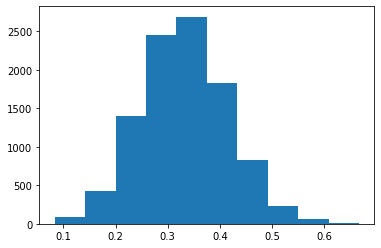

Expected accuracy of a random classifier 0.33392777777777777


In [41]:
from matplotlib import pyplot as plt

accuracies = []
for _ in range(10000):
    ys_test_pred_random = np.random.randint(1, 4, len(ys_test))
    accuracies.append(accuracy(ys_test, ys_test_pred_random))

plt.hist(accuracies)
plt.show()

print('Expected accuracy of a random classifier', np.mean(accuracies))

Does this accuracy make sense? Is this accuracy similar to the one you had predicted?

# The k-Nearest Neighbor Algorithm

We will now extend the NN algorithm to develop the k-Nearest Neighbor (kNN) algorithm.
By extending the NN algorithm we avoid repeating the training code. This is in fact the same.
In the classification method, in order to avoid the sorting of
all the examples after having measured their score, we will make use of priority queues, which allow us to keep track
only of the first $k$-nearest examples, making the code more efficient. You are free to implement the version where
first all the examples are scored, then sorted and selected. These two versions, if correctly implemented,
should produce to the same result.

In [42]:
from statistics import mode
from heapq import heappush, heappushpop

class KNN(NN):

    def __init__(self, distance):
        super().__init__(distance)

    def closest_training_examples(self, x_q, k=1):
        k_nearest = []

        # initialize an heap with k elements
        for x, y  in self.training_examples[:k]:
            score = self.distance(x_q, x)
            heappush(k_nearest, (-score, (x, y)))

        # find the k-nearest example
        for x, y in self.training_examples[k:]:
            score = self.distance(x_q, x)
            heappushpop(k_nearest, (-score, (x, y)))

        # we no longer need to keep the score
        res = [(x, y) for _, (x, y) in k_nearest]
        return res

    def classify(self, x_q, k = 1):
        # find the k closest
        k_nearest_xs, k_nearest_ys = zip(*self.closest_training_examples(x_q, k))
        # return the mode
        return mode(k_nearest_ys)

We now train and test this algorithm in the same way we did for the NN algorithm.

In [43]:
knn_clf = KNN(euclidean_distance)

knn_clf.add_examples(xs_train, ys_train)

ys_train_pred = []
for x in xs_train:
    y_hat = knn_clf.classify(x)
    ys_train_pred.append(y_hat)

ys_test_pred = []
for x in xs_test:
    y_hat = knn_clf.classify(x)
    ys_test_pred.append(y_hat)

print('Train accuracy of kNN', accuracy(ys_train, ys_train_pred))
print('Test accuracy of kNN', accuracy(ys_test, ys_test_pred))

Train accuracy of kNN 1.0
Test accuracy of kNN 1.0


Nothing has changed with respect to the NN algorithm because we have implicitly used $k=1$. Let's now try $k=5$.

In [44]:
ys_train_pred = []
for x in xs_train:
    y_hat = knn_clf.classify(x, 5)
    ys_train_pred.append(y_hat)

ys_test_pred = []
for x in xs_test:
    y_hat = knn_clf.classify(x, 5)
    ys_test_pred.append(y_hat)


print('Train accuracy of kNN', accuracy(ys_train, ys_train_pred))
print('Test accuracy of kNN', accuracy(ys_test, ys_test_pred))

Train accuracy of kNN 0.9647887323943662
Test accuracy of kNN 0.9722222222222222


It seems that considering more points did not help. Note that this time the training accuracy has changed. Can you
explain why?

## kNN in Scikit-Learn

We will now learn how to use the kNN implementation of scikit-learn.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

To train the classifier.

In [ ]:
knn_clf.fit(xs_train, ys_train)

We now evaluate the result of this classifier. Here, we should not see any
difference with respect to the results obtained above with our implementation of the kNN algorithm.

In [ ]:
from sklearn.metrics import accuracy_score

ys_test_pred = knn_clf.predict(xs_test)

print('Test accuracy of kNN', accuracy_score(ys_test, ys_test_pred))

Let's now try the cosine distance.

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=1, metric='cosine')

knn_clf.fit(xs_train, ys_train)

ys_test_pred = knn_clf.predict(xs_test)

print('Test accuracy of kNN', accuracy_score(ys_test, ys_test_pred))

Try other $n$ values. Can you find a better one? The danger of doing this hyper-parameter exploration using the test set is
that we may overfit these hyper-parameters on the test set.
To avoid this, it is better to find the best hyper-parameter values via a validation strategy.

To find these hyper-parameter values we can exploit the grid search of scikit-learn. This will perform a k-fold
cross-validation on the training set.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'weights': ["uniform", "distance"],
    'n_neighbors': range(1, 11),
    'metric':['euclidean', 'manhattan', 'cosine']}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=2)
grid_search.fit(xs_train, ys_train)

We can now see what are the best hyper-parameter values found by the cross-validation.

In [ ]:
grid_search.best_estimator_

Let's now try this hyper-parameters on the test set.

In [ ]:
knn_clf = KNeighborsClassifier(metric='cosine', n_neighbors=4, weights='distance')

knn_clf.fit(xs_train, ys_train)

ys_train_pred = knn_clf.predict(xs_train)
ys_test_pred = knn_clf.predict(xs_test)

print('Train accuracy of kNN', accuracy(ys_train, ys_train_pred))
print('Test accuracy of kNN', accuracy(ys_test, ys_test_pred))

The accuracy measured on the test set is now a better estimate of the accuracy we would expect on unseen examples.

# Support Vector Machines

Here I will introduce you how to use the Support Vector Machine (SVM) implementation of scikit-learn.

Note how we are setting the $C$ hyper-parameter of SVM. $C$ controls the trade-off between having a small and strict
margin and a wider and loose margin. Following we will set $C$ to infinity which makes the margin infinitely strict.
This means that based on the dataset, the fitting of the SVM may fail if the training algorithm fails to separate all
the training examples perfectly.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=float("inf"))

We now train this classifier.

In [ ]:
svm_clf.fit(xs_train, ys_train)

The training went well, which means that the SVM training algorithm managed to perfectly fit the training examples.
We can now verify this on the training set. We will also test the performance of this classifier on the test set.

In [ ]:
ys_train_pred = svm_clf.predict(xs_train)
ys_test_pred = svm_clf.predict(xs_test)

print('Train accuracy of SVM', accuracy(ys_train, ys_train_pred))
print('Test accuracy of SVM', accuracy(ys_test, ys_test_pred))

How would you find the best hyper-parameter C value? Try re-implement the code used to validate the kNN
classifier above.